# Popularity Prediction of User-Posts 
# on the website of Austrian Newspaper 'Der Standard'

This noteboook deal with the challenge of prediction the popularity (measured by up- and downvotes) of user-posts in the comments-section under articles of the Austrian Newspaper 'Der Standard'.

## Step 0: Set Up

In [1]:
 #!pip install jupyter_contrib_nbextensions
 #!jupyter contrib nbextension install --user

### Step 0.1 Load Libraries

As a first step we load in the necessary libraries that we will use to accomplish this task.

In [108]:
# Data manipulation
import pandas as pd
import numpy as np
import sqlite3

# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import textwrap

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
# deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate

# Text processing
import re
import string
from textblob import TextBlob
import spacy
#!pip install spacy
#!python -m spacy download de_core_news_sm

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# for tracking time
from tqdm import tqdm

### Step 0.2 Load Data

In [109]:
# Relative path to the SQLite database file
database_file = "./data/corpus.sqlite3"

# Connect to the database
conn = sqlite3.connect(database_file)

# Query to fetch the first 100,000 rows from a table named 'your_table_name'
query = "SELECT * FROM Posts"

# Load data into a DataFrame
df_posts = pd.read_sql_query(query, conn)
df_articles = pd.read_sql_query("SELECT * FROM Articles LIMIT 100000", conn)

# Close the connection
conn.close()


## Step 1: Preprocessing

In [112]:
# Extracting the subtitle from the articles body
def extract_subtitle(html_content):
    match = re.search(r'<h2.*?>(.*?)<\/h2>', html_content)
    return match.group(1) if match else " "
df_articles['Subtitle'] = df_articles['Body'].apply(extract_subtitle)


# Merge the two DataFrames based on the 'ID_Article' column

# excluding the full articles body and only including title and subtitle in the merge
# as the body is usually quite long and might not contain valuable information for this analysis
columns_to_merge = df_articles.columns[df_articles.columns != 'Body']

df_merged = pd.merge(df_posts, df_articles[columns_to_merge], on='ID_Article')


# Shuffle the dataset and reset index
df_merged = df_merged.sample(n=len(df_merged))
df_merged = df_merged.reset_index(drop=True)


# Preprocessing step to replace None with empty strings
df_merged['Body'] = df_merged['Body'].fillna('')
df_merged['Headline'] = df_merged['Headline'].fillna('')
# Ensure 'PositiveVotes' and 'NegativeVotes' columns are numeric
df_merged['PositiveVotes'] = pd.to_numeric(df_merged['PositiveVotes'], errors='coerce')
df_merged['NegativeVotes'] = pd.to_numeric(df_merged['NegativeVotes'], errors='coerce')
# Convert 'CreatedAt' and 'publishingDate' columns to datetime format
df_merged['CreatedAt'] = pd.to_datetime(df_merged['CreatedAt'], errors='coerce')
df_merged['publishingDate'] = pd.to_datetime(df_merged['publishingDate'], errors='coerce')
# Convert 'ID_Article' columns to numeric 
df_merged['ID_Article'] = pd.to_numeric(df_merged['ID_Article'], errors='coerce')



# Create the 'TotalInteraction' column
df_merged['TotalInteraction'] = df_merged['PositiveVotes'] + df_merged['NegativeVotes']
# Create Full Text column
df_merged['FullText'] =  df_merged['Headline'] + ' ' + df_merged['Body'] 
# Generate feature article_post_count
df_merged['article_post_count'] = df_merged['ID_Article'].map(df_merged['ID_Article'].value_counts())



###  Step 1.1 Removing Stop Words

In [ ]:
# Load the German language model from spaCy
nlp = spacy.load("de_core_news_sm")

# Example dataframe
# df_merged = pd.DataFrame({'FullText': ["Hier ist ein Beispieltext.", "Das ist ein weiterer Text."]})

# Function to calculate stop word ratio and remove stop words
def process_text(text):
    doc = nlp(text)
    
    # Count stop words and total words
    stop_words = [token.text for token in doc if token.is_stop]
    non_stop_words = [token.text for token in doc if not token.is_stop and token.is_alpha]
    
    # Calculate the ratio of stop words to other words
    if len(non_stop_words) > 0:
        stop_word_ratio = len(stop_words) / (len(non_stop_words) + len(stop_words))
    else:
        stop_word_ratio = 1  # Only stop words in text
    
    # Remove stop words
    cleaned_text = " ".join(non_stop_words)
    
    return stop_word_ratio, cleaned_text

# Apply the function to each row in the dataframe
df_merged[['StopWordRatio', 'CleanedText']] = df_merged['FullText'].apply(lambda text: process_text(text)).apply(pd.Series)

# Check results
print(df_merged[['FullText', 'StopWordRatio', 'CleanedText']])


###  Step 1.2 Generate Ratio - Positive/Negative Votes For Regression

In [113]:
# Create a new column for the ratio of Negative to Positive Votes
# Define conditions
conditions = [
    (df_merged['PositiveVotes'] > 0) & (df_merged['NegativeVotes'] == 0),  # Only positive votes
    (df_merged['NegativeVotes'] > 0) & (df_merged['PositiveVotes'] == 0),  # Only negative votes
    (df_merged['PositiveVotes'] == df_merged['NegativeVotes']),            # Equal positive and negative votes
    (df_merged['PositiveVotes'] > df_merged['NegativeVotes']),             # More positive votes
    (df_merged['NegativeVotes'] > df_merged['PositiveVotes'])              # More negative votes
]
# Define corresponding values for each condition
values = [
    1,  # Only positive votes
    -1,  # Only negative votes
    0,  # Equal positive and negative votes
    ((df_merged['PositiveVotes'] / df_merged['TotalInteraction']) - 0.5)*2,  # Positive outnumber negative
    ((-(df_merged['NegativeVotes'] / df_merged['TotalInteraction']) + 0.5))*2  # Negative outnumber positive
]
# Create the new column 'Neg_Pos_Ratio'
df_merged['Neg_Pos_Ratio'] = np.select(conditions, values, default=0)

#looking at come examples
df_merged[["PositiveVotes", "NegativeVotes", "Neg_Pos_Ratio"]].head(10)

,PositiveVotes,NegativeVotes,Neg_Pos_Ratio
0,3,0,1.000000
1,6,1,0.714286
2,0,0,0.000000
3,23,0,1.000000
4,0,2,-1.000000
5,2,0,1.000000
6,3,2,0.200000
7,1,1,0.000000
8,0,0,0.000000
9,22,4,0.692308


###  Step 1.2 Generate Labels For Classification

In [114]:
# Initialize all as 'regular post'
df_merged['Post_Engagement'] = 'regular post'
post_counts = df_merged['ID_Article'].value_counts()

# Dictionary to store thresholds for each article with enough posts
top_thresholds = {}

# Calculate top 40% threshold for articles with more than 10 posts
for articleid, count in post_counts.items():
    if count > 10:
        # Only calculate threshold for articles with 50 or more posts
        top_thresholds[articleid] = np.percentile(
            df_merged.loc[df_merged['ID_Article'] == articleid, 'TotalInteraction'],
            60  # 100 - 40 for the top 40% threshold
        )

# Apply 'top post' label using precomputed thresholds
mask_top_post = df_merged['ID_Article'].map(top_thresholds).notnull() & \
                (df_merged['TotalInteraction'] > df_merged['ID_Article'].map(top_thresholds))
df_merged.loc[mask_top_post, 'Post_Engagement'] = 'top post'

# Check the resulting split into regular and normal posts
df_merged['Post_Engagement'].value_counts()


regular post    654426
top post        357347
Name: Post_Engagement, dtype: int64

**Looking at an example** - Posts on the Article with ID 103

In [115]:
df_merged[df_merged['ID_Article'] == 103][["FullText", "article_post_count", 
                                           "PositiveVotes", "NegativeVotes", "TotalInteraction", "Post_Engagement"]]

,FullText,article_post_count,PositiveVotes,NegativeVotes,TotalInteraction,Post_Engagement
135368,Ich stehe ja auf das Mozart Eis und Raphaello...,12,0,0,0,regular post
182747,"""...und der Eisverkäufer ruft ""Gelati Gelati""...",12,0,0,0,regular post
196310,"""Eh, wasse wolle due, hä?""",12,1,0,1,top post
308316,"Wann gibt es endlich wieder Cassata, Peach-Me...",12,4,0,4,top post
312817,Laienhaft frage ich nach: Fuer mich wirkt das ...,12,0,0,0,regular post
444281,"Ausbildung in Italien gut und schön, aber mus...",12,0,0,0,regular post
540265,Danke für den Tip. Werde dort vorbei schauen.,12,1,0,1,top post
572116,"Cassata gibt's in der krugerstraße, derzeit m...",12,0,0,0,regular post
656939,Cassata geht mir in Wien auch furchtbar ab. M...,12,0,0,0,regular post
914030,Eis das mit der Spachtel aufgetragen wird ist...,12,0,0,0,regular post


## Step 2: Explorative Data Analysis 

In order to develop a feeling for the data, step 1 focuses on analyzing and visualizing the dataset.



### Step 2.0. Histogram of Negative Positive Ratio 

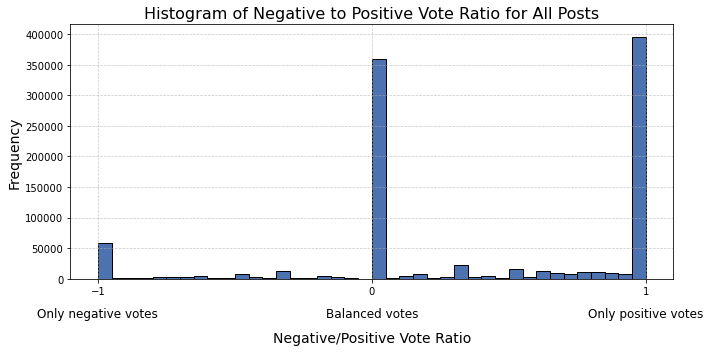

In [37]:
# Filter the data for "top posts" and plot a histogram for the Neg/Pos ratio
top_posts = df_merged

# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(top_posts['Neg_Pos_Ratio'].dropna(), bins=40, edgecolor='black')
plt.title('Histogram of Negative to Positive Vote Ratio for All Posts', fontsize=16)
plt.xlabel('Negative/Positive Vote Ratio', fontsize=14, labelpad=35)  # Add margin using labelpad
plt.ylabel('Frequency', fontsize=14)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate x axsis for improved clarity
plt.annotate('Only positive votes', xy=(1, 0), xytext=(1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )

plt.annotate('Balanced votes', xy=(0, 0), xytext=(0, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

plt.annotate('Only negative votes', xy=(-1, 0), xytext=(-1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )
plt.xlim(-1.1, 1.1)
plt.xticks([-1, 0, 1])

# Show the plot
plt.tight_layout()
plt.show()

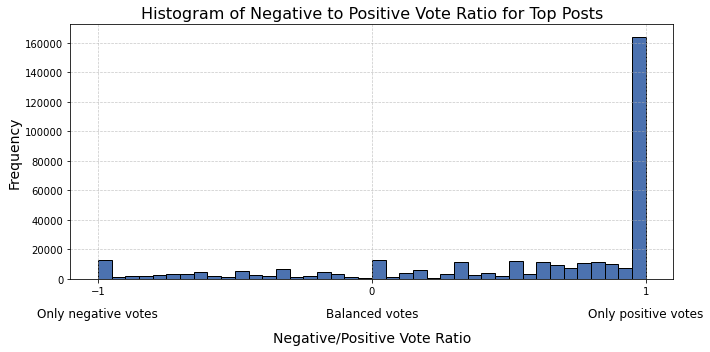

In [35]:
# Filter the data for "top posts" and plot a histogram for the Neg/Pos ratio
top_posts = df_merged[df_merged['Post_Engagement'] == 'top post']

# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(top_posts['Neg_Pos_Ratio'].dropna(), bins=40, edgecolor='black')
plt.title('Histogram of Negative to Positive Vote Ratio for Top Posts', fontsize=16)
plt.xlabel('Negative/Positive Vote Ratio', fontsize=14, labelpad=35)  # Add margin using labelpad
plt.ylabel('Frequency', fontsize=14)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate x axsis for improved clarity
plt.annotate('Only positive votes', xy=(1, 0), xytext=(1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )

plt.annotate('Balanced votes', xy=(0, 0), xytext=(0, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

plt.annotate('Only negative votes', xy=(-1, 0), xytext=(-1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )
plt.xlim(-1.1, 1.1)
plt.xticks([-1, 0, 1])

# Show the plot
plt.tight_layout()
plt.show()

### Step 2.1. Boxplot of Positive & Negative Votes

In order to get a feeling for how the values of Up- and Downvotes are distributed, we generate two boxplots, one for the upvotes feature, and one for the downvotes feature.

In [4]:
def make_box_plot(column, df):
    """
    Function to create a boxplot for a column in the dataframe
    Inputs:
    Name of the Column to make boxplot for (string)
    A Pandas data frame object 
    """

    # Set style
    sns.set_style("whitegrid")

    # Adjust the figure size
    plt.figure(figsize=(8, 2))

    # Create the box plot
    ax = sns.boxplot(x=df_posts[column], orient='h', fliersize=1, color='lightblue')

    # Set title
    ax.set_title("Distribution of " + column +  " (Log Scale)", fontsize=16)

    # Set x-axis label
    ax.set_xlabel("Number of "+ column, fontsize=14)

    # Remove y-axis label
    ax.set_ylabel("")

    # Set logarithmic scale for x-axis
    ax.set_xscale('log')

    # Set ticks on the x-axis
    custom_ticks = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 50, 100, 500]
    plt.xticks(custom_ticks, [str(i) for i in custom_ticks], fontsize=16)

    # Remove top and right spines
    sns.despine()
    
    # Save the plot
    plt.savefig('./figures/boxplot_' + column + '.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()

    


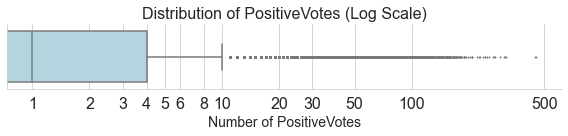

In [5]:
make_box_plot('PositiveVotes', df_posts)

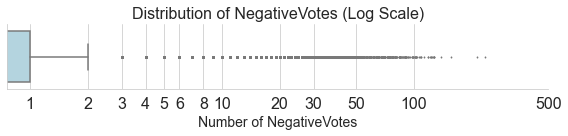

In [6]:
make_box_plot('NegativeVotes', df_posts)

### Step 2.2. Heatmap of Positive and Negtive Votes

In order to analyzse the distribution further, a heatmap is generated.

In [7]:
# Define custom intervals for PositiveVotes and NegativeVotes
positive_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]
negative_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]

# Create result DataFrame with named columns and rows
result_df = pd.DataFrame(0, index=[f'{interval[0]}-{interval[1]}' for interval in negative_intervals],
                         columns=[f'{interval[0]}-{interval[1]}' for interval in positive_intervals])

# Iterate through each post and update the count in the result DataFrame
for _, row in df_posts.iterrows():
    neg_interval = None
    pos_interval = None

    
    # Find the index of the negative interval
    for i, interval in enumerate(negative_intervals):
        if interval[0] <= row['NegativeVotes'] <= interval[1]:
            neg_interval = i
            break
            
    # Find the index of the positive interval
    for i, interval in enumerate(positive_intervals):
        if interval[0] <= row['PositiveVotes'] <= interval[1]:
            pos_interval = i
            break
    
    if neg_interval is not None and pos_interval is not None:
        result_df.iloc[neg_interval, pos_interval] += 1
        # row = interval for downvoates - column = interval for upvotes


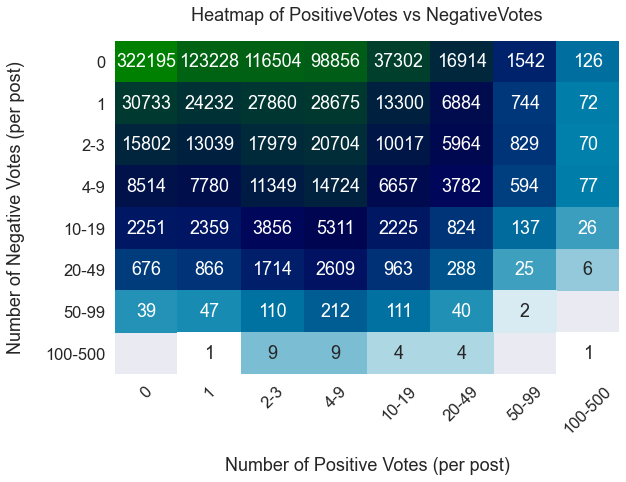

In [8]:

# Rename columns and index
result_df.rename(columns={'1-1': '1', '0-0': '0'}, 
                 index={'1-1': '1', '0-0': '0'}, 
                 inplace=True)

# Get the colormap 
cmap = cm.get_cmap('ocean')
# Flip the colormap
flipped_cmap = cmap.reversed()

# Set font scale for the heatmap and axis labels
sns.set(font_scale=1.5)  # Adjust font scale as needed

# Plot heatmap for PositiveVotes with logarithmic color scale
plt.figure(figsize=(10, 8))
sns.heatmap(result_df, cmap=flipped_cmap, annot=True, fmt='d', cbar=False, 
            norm=LogNorm(vmin=1, vmax=result_df.max().max()))
plt.title('Heatmap of PositiveVotes vs NegativeVotes', pad=20)  # Adjust title padding
plt.xlabel('Number of Positive Votes (per post)', labelpad=20)  # Adjust x label padding
plt.ylabel('Number of Negative Votes (per post)', labelpad=20)  # Adjust y label padding
plt.xticks(rotation=45)  # Rotate x ticks for better visibility
plt.yticks(rotation=0)   # Rotate y ticks for better visibility
plt.tight_layout(pad=3.0)  # Adjust padding between plot and figure edges


plt.savefig("./figures/heatmap.png", dpi=300, bbox_inches='tight' )
plt.show()


### Step 2.3. Overview of all posts

Next we generate an overview about how many posts have at least one vote (positive or negative), at least one positive or at least one negative votes.

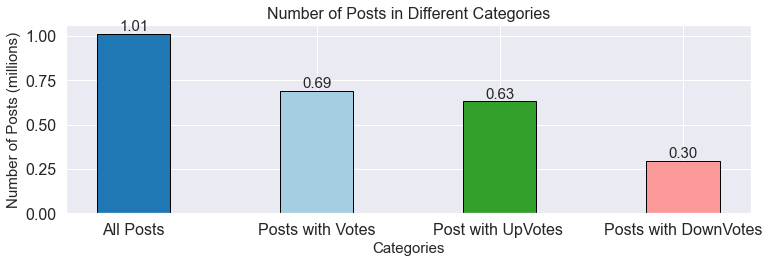

In [9]:
all_posts = df_posts["ID_Post"].count()
all_posts_with_votes = df_posts[(df_posts["PositiveVotes"] > 0) | (df_posts["NegativeVotes"] > 0)]["ID_Post"].count()
positive_posts = df_posts[(df_posts["PositiveVotes"] > 0)]["ID_Post"].count()
negative_posts = df_posts[(df_posts["NegativeVotes"] > 0)]["ID_Post"].count()

# Convert values to millions
all_posts /= 1e6
all_posts_with_votes /= 1e6
positive_posts /= 1e6
negative_posts /= 1e6

# Define categories and their corresponding values
categories = ['All Posts', 'Posts with Votes', 'Post with UpVotes ', 'Posts with DownVotes']
values = [all_posts, all_posts_with_votes, positive_posts, negative_posts]

# Choose a more suitable color palette
colors = ['#1F78B4', '#A6CEE3',   '#33A02C', '#FB9A99']
# Create bar plot
plt.figure(figsize=(11, 4))
bars = plt.bar(categories, values, color=colors, 
               edgecolor='black', width=0.4)  

# Add labels and title
plt.xlabel('Categories', fontsize=15)
plt.ylabel('Number of Posts (millions)', fontsize=15)
plt.title('Number of Posts in Different Categories', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the value on top of each bar with larger font size
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=15)

# Save the plot
plt.savefig('./figures/bar_plot.png', dpi=300, bbox_inches='tight')
# Show plot
plt.tight_layout()
plt.show()



In [10]:
print(f"The median number of Upvotes is: { df_posts.PositiveVotes.median() }")
print(f"The median number of Downvotes is: { df_posts.NegativeVotes.median() }")


print(f"The mean number of Upvotes is: { df_posts.PositiveVotes.mean() }")
print(f"The mean number of Downvotes is: { df_posts.NegativeVotes.mean() }")

The median number of Upvotes is: 1.0
The median number of Downvotes is: 0.0
The mean number of Upvotes is: 3.7803005219550236
The mean number of Downvotes is: 1.0835434430450308


### Step 2.4. Looking at the Data

Next we look at a few example for posts with more than 10 upvotes or posts with more than 10 downvotes.

In [11]:
df_posts[df_posts["PositiveVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
108,,Ist es schon überarbeitet? Ich möchte wieder so berühmt werden wie früher. Das hat mir damals sagenhaft viele perverse Kontakte verschafft.
109,"""Multiuser"" und ""Bewertungsuser""?","Gibt es eine Meldeadresse/-stelle an die man sich wenden kann, wenn man annimmt einen ""Multiuser"" (mehrfach registrierten Benutzer) gefunden zu haben? Und was ist mit Usern die schon länger registriert sind, selbst 0 Postings verfasst haben und in Threads auffallend oft von oben bis unten durchgehend nur mit rot oder grün bewerten?"
157,Zugriff zu den eigenen ...,...posts bzw. Konto wäre eine gute Erweiterung....
189,"Oh, wie schön, heute ist m e i n Tag! :-)","Beste Grüße an alle Mit-Lefties dieser Erde und auch Nicht-Erde!!! Erfahrungen: # wirkliche Probleme, sehr eindrücklich als Kind zB beim Werken/Basteln, haben mir immer bestimmte Scheren gemacht (die z.B. dann total in der Hand weh tun, wenn links gehalten, oder einfach eher reißen als schneiden) # das eindrücklichste Erlebnis ist ein paar Jahre her: in einer Café-Lokation auf der Wiener Währinger Straße wurde mir meine Melange in einer Tasse serviert, deren ""ergonomisch"" schiefer/geschwungener Griff für eine rechte Hand (wohl) sehr gut passt - mit der linken Hand kann man das Häferl dadurch aber praktisch kaum halten... # beim Sporteln war mein Lefty-tum, glaub ich, immer nur ein Vorteil :-) ;-)"
206,,"wenn mir jemand bezüglich meiner handwerklichen Fähigkeiten gesagt hat, dass ich zwei Linke habe, habe ich mich für das Komplement bedankt."
215,,"am allerschlimmsten sind saucenschöpfer mit schnabel... da kann ich machen was ich will, ich kann diese teile einfach nicht bedienen.. die sauce rinnt überall hin, nur nicht auf den teller..."
289,,"Die Meinl-Häferln sind wirklich eine sinnlose Geschichte. Glückwunsch an den Designer für Hirnlosigkeit im Dienst - auch wenn es Linkshänder-Exemplare theoretisch geben tät, kein Restaurant würde die bestellen. Scheren sind ein kleines Problem, wobei ich mir mit einer Linkshänderschere auch weh tu - weil schon zu lange an die falschen Scheren gewohnt. Wenn man sich aber ausschließlich mit Linkshänderprodukten umgibt, ""sperrt"" man sih quasi von der dominierenden Rechtshänderwelt ab. Letztendlich drängt einem das Linkshändertum ein wenig, den Individualisten zu spielen - mir hat's nicht geschadet, oder ich merk's nicht."
297,,"Meine Großmutter hat mir mal erzählt, dass sie in der Schule noch geohrfeigt wurde, weil sie Linkshänderin war. Umlernen wurde gefordert, nicht nur in der Schule, sondern auch vom Elternhaus (natürlich auch mit Prügel verbunden) - kann mir nicht vorstellen, was für Leid das in einem Kind/Jugendlichen verursacht, wegen so einer Lappalie unter Druck gesetzt und verdroschen zu werden. Heute kann sie beide Hände fast gleich nutzen, präferiert bei den meisten Sachen jedoch die Linke."
347,,"Als Linkshänder, welcher die Computer Maus mit der rechten bedient, kann ich gleichzeitig etwas (ab)schreiben und mit der Maus am Computer zB Textstellen markieren und scrollen ;)"
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot


In [12]:
df_posts[df_posts["NegativeVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
235,,Zum Sport: Wer schießt (wie ich) beim Fußball mit rechts? Wer ist links unterwegs? rot=links grün=rechts
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot
759,,"schön. Bis zu jenem Tag, als die Trabis die Mariahilferstraße verstopft haben mit den Waschmaschinen am Dachl."
884,,"Ich hab jene Ostdeutschen bedauert, die den Versprechungen von Kohl und Genscher geglaubt haben."
1085,,"Wenn das so schlimm war, wieso hast sie dann überhaupt wiedergesehen? Oder wars nur für eine Nacht?"
1113,,das is ja wirklich grauslich - ich hätt' Euch auch nicht rein gelassen
1120,,In London gibts außergewöhnlich gute Hotels. Man muss sie sich halt leisten können und wollen. ;-)
1123,,DAnn frage ich dich nochmal: Was war damals an dem Erlebnis so schlimm?
1129,,"Im Nachhinein ist was anderes, ich glaube, hier gehts darum, welches Hotelerlebnis man im Moment des Erlebens als schlimm empfand. Also eher off topic, hier von kaputten späteren Beziehungen zu plaudern. :-)"
1251,,"dann graust mir davor, wie Dich Deine Ex-Frau umgedreht hat *brr*"


Most interestingly we see here for example that users misuse the functionality the downvotes and upvotes to start a survey (as shown in the first two rows).

## Step 2: Feature Generation

Next we generate the features to train our models with.

In [118]:
# Calculate the time difference in hours between 'CreatedAt' and 'publishingDate'
df_merged['publication_time'] = ( df_merged['CreatedAt'] - df_merged['publishingDate'] ).dt.total_seconds() / 60 / 60

# Rank the comments for each article based on the 'time_passed_before_post_creation'
df_merged['publication_rank'] = df_merged.groupby('ID_Article')['publication_time'].rank(method='first').astype(int)

# Calculate the percentage rank (to check if it's in the first 10%, 20%, etc.)
df_merged['publication_percentile'] = df_merged.groupby('ID_Article')['publication_time'].rank(pct=True)

# Create a column to define percentile category
def assign_percentile_category(percentile):
    if percentile <= 0.5:
        # First 10%, 20%, ... up to 50%
        return f"First {int(percentile * 10) * 10 +10}%"
    else:
        # Last 40%, 30%, ... up to 10%
        return f"Last {int((1 - percentile) * 10) * 10 +10}%"

df_merged['publication_percentile_category'] = df_merged['publication_percentile'].apply(assign_percentile_category)


In [121]:


# Pre-compile regex patterns for reuse
patterns = {
    'exclamation': re.compile(r'!'),
    'questionmark': re.compile(r'\?'),
    'period': re.compile(r'\.'),
    'quote': re.compile(r'["\']'),
    'hashtag': re.compile(r'#'),
    'capital_letter': re.compile(r'[A-Z]'),
    'full_capital_words': re.compile(r'\b[A-Z]{2,}\b'),
    'emoji': re.compile(r'[\U0001F600-\U0001F64F]'),
    'punctuation': re.compile(f'[{string.punctuation}]'),
    'exaggeration': re.compile(r'!!|\?\?'),
    'short_words': re.compile(r'\b\w{1,3}\b'),
    'long_words': re.compile(r'\b\w{10,}\b'),
    'gratitude': re.compile(r'danke|bitte|lieb', re.IGNORECASE)
}

def calculate_frequency(text, pattern):
    """Calculate the frequency of a given pattern in the text."""
    return len(pattern.findall(text)) if text else 0

def calculate_ratio(numerator, denominator):
    """Calculate the ratio of two values, returns 0 if denominator is zero."""
    return numerator / denominator if denominator != 0 else 0

def extract_features(df):
    """Integrate all features into the dataframe based on the full text column."""
    feature_rows = []

    for full_text in df['FullText']:
        # Count word frequencies
        word_count = len(full_text.split())
        punctuation_count = sum(c in string.punctuation for c in full_text)
        sentences = re.split(r'[.!?]', full_text)
        unique_words = len(set(full_text.split()))
        
        # Pre-compute frequencies
        frequencies = {
            'exclamation_frequency': calculate_frequency(full_text, patterns['exclamation']),
            'questionmark_frequency': calculate_frequency(full_text, patterns['questionmark']),
            'period_frequency': calculate_frequency(full_text, patterns['period']),
            'quote_frequency': calculate_frequency(full_text, patterns['quote']),
            'hashtag_frequency': calculate_frequency(full_text, patterns['hashtag']),
            'capital_letter_frequency': calculate_frequency(full_text, patterns['capital_letter']),
            'full_capital_words_frequency': calculate_frequency(full_text, patterns['full_capital_words']),
            'exaggeration_frequency': calculate_frequency(full_text, patterns['exaggeration']),
            'short_words_frequency': calculate_frequency(full_text, patterns['short_words']),
            'long_words_frequency': calculate_frequency(full_text, patterns['long_words']),
            'spelling_mistakes': 1 if re.search(r'\.\s*[a-zäöüß]|und[a-zäöüß]|oder[a-zäöüß]', full_text) else 0,
        }

        # Calculate ratios
        ratios = {
            'emoji_to_text_ratio': calculate_ratio(calculate_frequency(full_text, patterns['emoji']), len(full_text)),
            'punctuation_to_text_ratio': calculate_ratio(punctuation_count, len(full_text)),
            'title_to_body_ratio': calculate_ratio(len(full_text.split()), len(full_text.split()) + 1),  # Simplified for demonstration
            'diversity_ratio': calculate_ratio(unique_words, word_count),
            'avg_sentence_length': calculate_ratio(word_count, len(sentences) - 1) if len(sentences) > 1 else 0,
            'avg_word_length': calculate_ratio(sum(len(word) for word in full_text.split()), word_count),
            'words_per_100_chars': calculate_ratio(word_count, len(full_text) / 100) if len(full_text) > 0 else 0,
        }

        # Combine features
        combined_features = {**frequencies, **ratios, 
                             'unique_words': unique_words,
                             'character_count': len(full_text),
                             'sentence_count': max(len(sentences) - 1, 1),
                             'gratitude_words': 1 if re.search(patterns['gratitude'], full_text) else 0}
        
        feature_rows.append(combined_features)

    # Convert feature rows to DataFrame and merge with the original df
    feature_df = pd.DataFrame(feature_rows)
    df = pd.concat([df.reset_index(drop=True), feature_df], axis=1)

    return df

# Apply feature extraction
df_merged = extract_features(df_merged)


In [122]:
df_merged.drop(columns=["Body","FullText"], inplace=False).head(2).style

,ID_Post,ID_Parent_Post,ID_Article,ID_User,CreatedAt,Status,Headline,PositiveVotes,NegativeVotes,Path,publishingDate,Title,Subtitle,TotalInteraction,article_post_count,Neg_Pos_Ratio,Post_Engagement,publication_time,publication_rank,publication_percentile,publication_percentile_category,exclamation_frequency,questionmark_frequency,period_frequency,quote_frequency,hashtag_frequency,capital_letter_frequency,full_capital_words_frequency,exaggeration_frequency,short_words_frequency,long_words_frequency,spelling_mistakes,emoji_to_text_ratio,punctuation_to_text_ratio,title_to_body_ratio,diversity_ratio,avg_sentence_length,avg_word_length,words_per_100_chars,unique_words,character_count,sentence_count,gratitude_words
0,503520,503495.000000,5968,1493,2015-12-02 01:55:00.207000,online,,3,0,Newsroom/User/Userkommentare,2015-12-01 14:43:57,"Edeka-Spot: Manipulativ, übergriffig und zynisch","Man fragt sich, was die Marke Edeka berechtigt, als nationaler Familientherapeut aufzutreten",3,311,1.000000,regular post,11.184224,132,0.424437,First 50%,0,0,1,0,0,4,0,0,5,2,0,0.000000,0.016529,0.944444,1.000000,17.000000,6.117647,14.049587,17,121,1,0
1,248305,248304.000000,2955,10353,2015-08-28 17:12:37.643000,online,,6,1,Newsroom/Panorama/Weltchronik,2015-08-28 16:30:13,Tote Frau im Koffer in Berlin: Mutmaßlicher Mörder festgenommen,Zweieinhalb Monate nach Leichenfund in Deutschland,7,5,0.714286,regular post,0.706845,2,0.400000,First 50%,0,0,3,0,0,3,0,0,4,1,1,0.000000,0.177215,0.500000,1.000000,0.333333,78.000000,1.265823,1,79,3,0


## Step 3: Define Models

Next we define a function to train our models and we dfine our baselines

## Step 4: Train & Evaluate Models

In [ ]:
# Define the initial X and y
X = df_merged.drop(columns=['PositiveVotes', 'NegativeVotes', 'TotalInteraction', 'Neg_Pos_Ratio', 'Post_Engagement'])
y = df_merged[['Post_Engagement', 'PositiveVotes']]

# Perform the train-test split only once
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_classification = y_train['Post_Engagement']
y_test_classification = y_test['Post_Engagement']

y_train_regression = y_train['PositiveVotes']
y_test_regression = y_test['PositiveVotes']

# Function to tokenize and pad the textual data
def preprocess_text_column(column, tokenizer=None, max_len=100):
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(column)
    
    sequences = tokenizer.texts_to_sequences(column)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    return padded_sequences, tokenizer

# Preprocess text columns in train and test sets
max_len = 100
X_train_body, body_tokenizer = preprocess_text_column(X_train['Body'], max_len=max_len)
X_test_body = pad_sequences(body_tokenizer.texts_to_sequences(X_test['Body']), maxlen=max_len, padding='post')

X_train_headline, headline_tokenizer = preprocess_text_column(X_train['Headline'], max_len=max_len)
X_test_headline = pad_sequences(headline_tokenizer.texts_to_sequences(X_test['Headline']), maxlen=max_len, padding='post')

# Scale temporal features in train and test sets
scaler = StandardScaler()
X_train_temporal = scaler.fit_transform(X_train[['publication_time', 'publication_rank']])
X_test_temporal = scaler.transform(X_test[['publication_time', 'publication_rank']])


# Prepare labels
y_train_classification = (y_train_classification == 'top post').astype(int)  
y_test_classification = (y_test_classification == 'top post').astype(int)  

## Regression Task

Finally we evaluate the models

In [ ]:
random_forest_regression = RandomForestRegressor(
                n_estimators=500,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=15,          # Limit depth to avoid overfitting
                min_samples_split=10,  # Require more samples to split
                min_samples_leaf=5,    # Require more samples at leaf
                max_features='sqrt'    # Consider fewer features at each split
            )


regression_models = {
    'Baseline': y_train_regression.mean(), 
    'Explainable Model 1': ['unique_words', 'character_count'],
    'Explainable Model 2': ['exclamation_frequency', 'questionmark_frequency', 'period_frequency',
            'quote_frequency', 'hashtag_frequency', 'capital_letter_frequency', 'full_capital_words_frequency',
            'emoji_to_text_ratio', 'punctuation_to_text_ratio', 'exaggeration_frequency', 'spelling_mistakes',
            'short_words_frequency', 'long_words_frequency', 'unique_words', 'character_count', 'sentence_count',
            'title_to_body_ratio', 'diversity_ratio', 'gratitude_words', 
            'avg_sentence_length', 'avg_word_length', 'words_per_100_chars', 'sentiment_score',                          
            'publication_time', 'publication_rank', 'publication_percentile','article_post_count']
}

In [ ]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units)(embedding_body)
# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units)(embedding_headline)
# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')
# Concatenate all inputs
concatenated = concatenate([lstm_body, lstm_headline, input_temporal])
# Output layer with linear activation for regression
output = Dense(1, activation='linear')(concatenated)
# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)
# Compile the model with a regression loss function
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

# Add the model to the regression models dictionary
regression_models['LSTM'] = model


In [ ]:
# Define the training function with RandomForestRegressor
def train_explainable_regression(features, y_train_regression):
    model = RandomForestRegressor()
    model.fit(X_train[features], y_train_regression)
    return model

def train_lstm_regression(model, X_train_body, X_train_headline, X_train_temporal, y_train_regression):
    history = model.fit(
        [X_train_body, X_train_headline, X_train_temporal], y_train_regression,
        epochs=3,  
        batch_size=32,
        validation_split=0.2
    )
    return model

def calculate_regression_metrics(y_true, y_pred):
    """Calculate regression metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

def evaluate_model_regression(y_train_regression, y_test_regression, model=None, 
                              predict_baseline=False, explainable=False, lstm=False, 
                              features=None):
    """Evaluate model or baseline regression."""
    if predict_baseline:
        y_pred_train = [y_train_regression.mean()] * len(y_train_regression)
        y_pred_test = [y_test_regression.mean()] * len(y_test_regression)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
    elif lstm:
        y_pred_train = model.predict([X_train_body, X_train_headline, X_train_temporal])
        y_pred_test = model.predict([X_test_body, X_test_headline, X_test_temporal])
    
    metrics_train = calculate_regression_metrics(y_train_regression, y_pred_train)
    metrics_test = calculate_regression_metrics(y_test_regression, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

def create_evaluation_df(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'MSE': metrics[0], 'MAE': metrics[1], 'R2': metrics[2]},
        {'Model': model_name, 'Evaluation': 'Test', 'MSE': metrics[3], 'MAE': metrics[4], 'R2': metrics[5]}
    ])

# Evaluate each model
evaluation_dfs = []

for model_name, X_baseline in regression_models.items():
    if model_name == 'Baseline':
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, predict_baseline=True)

    elif model_name.startswith('Explainable'):
        trained_model = train_explainable_regression(regression_models[model_name], y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, 
                                                         model=trained_model, explainable=True,
                                                         features=regression_models[model_name])
    elif model_name == 'LSTM':
        model = regression_models[model_name]
        trained_model = train_lstm_regression(model, X_train_body, X_train_headline, 
                                              X_train_temporal, y_train_regression)
        metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, model=model, lstm=True)
        
    # Save results
    evaluation_df = create_evaluation_df(model_name, metrics)
    evaluation_dfs.append(evaluation_df)

# Combine evaluation results into one DataFrame
evaluation_df_posts = pd.concat(evaluation_dfs, ignore_index=True)
evaluation_df_posts_sorted = evaluation_df_posts.sort_values(by='Evaluation', ascending=False)
print(evaluation_df_posts_sorted)


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Dense, concatenate, Input
from tensorflow.keras.models import Model

# Load the BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
bert_model = TFBertModel.from_pretrained("bert-base-german-cased")

# Define BERT input function
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# Define inputs
input_body_ids = Input(shape=(128,), dtype=tf.int32, name='body_input_ids')
input_body_mask = Input(shape=(128,), dtype=tf.int32, name='body_attention_mask')
input_headline_ids = Input(shape=(128,), dtype=tf.int32, name='headline_input_ids')
input_headline_mask = Input(shape=(128,), dtype=tf.int32, name='headline_attention_mask')

# BERT model for body input
bert_output_body = bert_model([input_body_ids, input_body_mask])[1]  # Use pooled output

# BERT model for headline input
bert_output_headline = bert_model([input_headline_ids, input_headline_mask])[1]

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate BERT outputs and temporal features
concatenated = concatenate([bert_output_body, bert_output_headline, input_temporal])

# Output layer with linear activation for regression
output = Dense(1, activation='linear')(concatenated)

# Define the BERT model
bert_regression_model = Model(inputs=[input_body_ids, input_body_mask, input_headline_ids, input_headline_mask, input_temporal], outputs=output)

# Compile the model for regression
bert_regression_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
bert_regression_model.summary()

# Add the model to the regression models dictionary
regression_models['BERT'] = bert_regression_model

# Define the training function for BERT model
def train_bert_regression(model, X_train_body_ids, X_train_body_mask, X_train_headline_ids, X_train_headline_mask, X_train_temporal, y_train_regression):
    history = model.fit(
        [X_train_body_ids, X_train_body_mask, X_train_headline_ids, X_train_headline_mask, X_train_temporal], y_train_regression,
        epochs=3,  # Increase epochs as needed
        batch_size=16,  # BERT models are memory-intensive; adjust batch size accordingly
        validation_split=0.2
    )
    return model

# Update the evaluate_model_regression function for BERT
def evaluate_model_regression(y_train_regression, y_test_regression, model=None, 
                              predict_baseline=False, explainable=False, lstm=False, bert=False, 
                              features=None):
    """Evaluate model or baseline regression."""
    if predict_baseline:
        y_pred_train = [y_train_regression.mean()] * len(y_train_regression)
        y_pred_test = [y_test_regression.mean()] * len(y_test_regression)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
    elif lstm:
        y_pred_train = model.predict([X_train_body, X_train_headline, X_train_temporal])
        y_pred_test = model.predict([X_test_body, X_test_headline, X_test_temporal])
    elif bert:
        y_pred_train = model.predict([X_train_body_ids, X_train_body_mask, X_train_headline_ids, X_train_headline_mask, X_train_temporal])
        y_pred_test = model.predict([X_test_body_ids, X_test_body_mask, X_test_headline_ids, X_test_headline_mask, X_test_temporal])
    
    metrics_train = calculate_regression_metrics(y_train_regression, y_pred_train)
    metrics_test = calculate_regression_metrics(y_test_regression, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

# Evaluate the BERT model
if 'BERT' in regression_models:
    bert_model = regression_models['BERT']
    trained_bert_model = train_bert_regression(bert_model, X_train_body_ids, X_train_body_mask, 
                                               X_train_headline_ids, X_train_headline_mask, 
                                               X_train_temporal, y_train_regression)
    metrics, y_pred_test = evaluate_model_regression(y_train_regression, y_test_regression, model=trained_bert_model, bert=True)
    evaluation_df = create_evaluation_df("BERT", metrics)
    evaluation_dfs.append(evaluation_df)

# Combine evaluation results into one DataFrame
evaluation_df_posts = pd.concat(evaluation_dfs, ignore_index=True)
evaluation_df_posts_sorted = evaluation_df_posts.sort_values(by='Evaluation', ascending=False)
print(evaluation_df_posts_sorted)


## Classification Task

In [ ]:
random_forest_classification = RandomForestClassifier(
                n_estimators=500,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=15,          # Limit depth to avoid overfitting
                min_samples_split=10,  # Require more samples to split
                min_samples_leaf=5,    # Require more samples at leaf
                max_features='sqrt'    # Consider fewer features at each split
            )


classification_models = {
    'Baseline': y_train_classification.mode()[0],  # Most frequent class ('regular post')
    'Explainable Model 1': ['BodyWordLength', 'HeadlineWordLength', 
                                    'BodyLength', 'HeadlineLength'],
    'Explainable Model 2': ['BodyWordLength', 'HeadlineWordLength', 
                         'BodyLength', 'HeadlineLength', 'Conjunctive', 
                         'Question', 'SpellingMistakes', 'Gratitude', 
                         'BodySentiment', 'HeadlineSentiment', 'ExclamationMarks', 
                         'UppercaseWordCount', 'PunctuationCount', 'AvgWordLength',
                         'LexicalDiversity', 'HasImportantKeywords', 
                         'HasPersonalPronouns', 
                         'time_passed_before_post_creation', 'time_percentile']
}

In [27]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64
# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units)(embedding_body)
# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units)(embedding_headline)
# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')
# Concatenate all inputs
concatenated = concatenate([lstm_body, lstm_headline, input_temporal])
# Output layer
output = Dense(1, activation='sigmoid')(concatenated)
# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


classification_models['LSTM'] = model



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 64)      39819008    ['body_input[0][0]']             
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 64)      8021824     ['headline_input[0][0]']         
                                                                                            

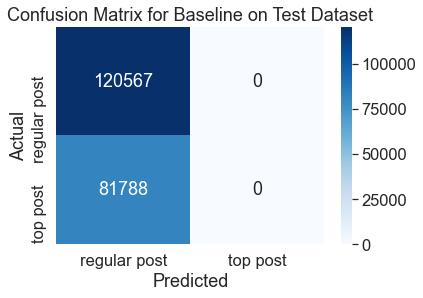

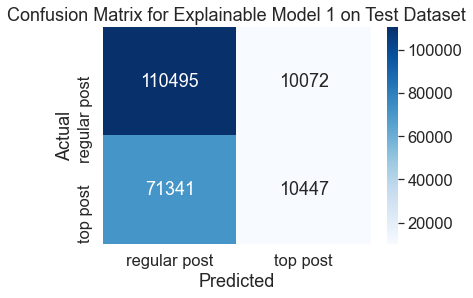

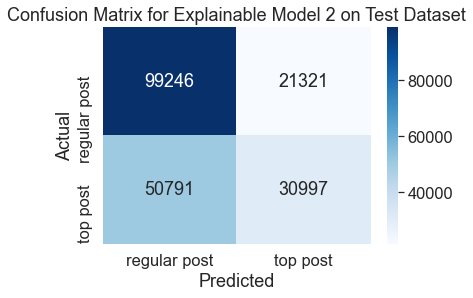

Epoch 1/3
20236/20236 [==============================] - 8310s 411ms/step - loss: 0.6349 - accuracy: 0.6338 - val_loss: 0.6254 - val_accuracy: 0.6458
Epoch 2/3
20236/20236 [==============================] - 8819s 436ms/step - loss: 0.5879 - accuracy: 0.6873 - val_loss: 0.6488 - val_accuracy: 0.6310
Epoch 3/3
6324/6324 [==============================] - 125s 20ms/step


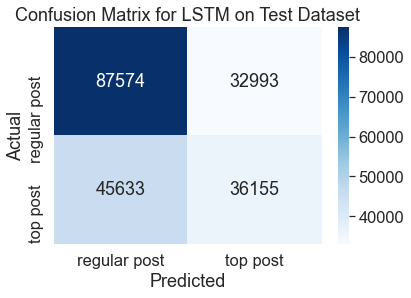

                 Model Evaluation  Accuracy  Precision    Recall        F1
0             Baseline      Train  0.596579   0.000000  0.000000  0.000000
2  Explainable Model 1      Train  0.626500   0.643441  0.166346  0.264351
4  Explainable Model 2      Train  0.672803   0.647295  0.415161  0.505869
6                 LSTM      Train  0.779978   0.763187  0.659134  0.707355
1             Baseline       Test  0.595819   0.000000  0.000000  0.000000
3  Explainable Model 1       Test  0.597672   0.509138  0.127733  0.204228
5  Explainable Model 2       Test  0.643636   0.592473  0.378992  0.462276
7                 LSTM       Test  0.611445   0.522864  0.442058  0.479077


In [28]:
# Define the training function with RandomForestClassifier
def train_explainable_classification(features, y_train_classification):
    model = random_forest_classification
    model.fit(X_train[features], y_train_classification)
    return model

def train_lstm_classification(model, X_train_body, X_train_headline, X_train_temporal, y_train_classification):
    history = model.fit(
        [X_train_body, X_train_headline, X_train_temporal], y_train_classification,
        epochs=3,  
        batch_size=32,
        validation_split=0.2
    )
    return model

def calculate_classification_metrics(y_true, y_pred):
    """Calculate classification metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['regular post', 'top post'], 
                yticklabels=['regular post', 'top post'])
    plt.title(f'Confusion Matrix for {model_name} on Test Dataset')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_model_classification(y_train_classification, y_test_classification, model=None, 
                                  predict_baseline=False, 
                                  explainable=False,
                                  lstm=False,
                                  features=None):
    """Evaluate model or baseline classification."""
    if predict_baseline:
        y_pred_train = [0] * len(y_train_classification)
        y_pred_test = [0] * len(y_test_classification)
    elif explainable:
        y_pred_train = model.predict(X_train[features])
        y_pred_test = model.predict(X_test[features])
    elif lstm:
        y_pred_train = (model.predict([X_train_body, X_train_headline, X_train_temporal]) > 0.5).astype(int)
        y_pred_test = (model.predict([X_test_body, X_test_headline, X_test_temporal]) > 0.5).astype(int)
    
    metrics_train = calculate_classification_metrics(y_train_classification, y_pred_train)
    metrics_test = calculate_classification_metrics(y_test_classification, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

    

def create_evaluation_df(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'Accuracy': metrics[0], 'Precision': metrics[1], 'Recall': metrics[2], 'F1': metrics[3]},
        {'Model': model_name, 'Evaluation': 'Test', 'Accuracy': metrics[4], 'Precision': metrics[5], 'Recall': metrics[6], 'F1': metrics[7]}
    ])




# Evaluate each model and plot confusion matrix
evaluation_dfs = []
examples_df = pd.DataFrame(columns=['ModelName',  # which model
                                    'Type', #weather true positive (tp), true negative (tn), fp or fn
                                    'Example', # the body of that example
                                    'PositiveVotes',
                                    'NegativeVotes'])

for model_name, X_baseline in classification_models.items():
    
    if model_name == 'Baseline':
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, predict_baseline=True)

    elif model_name[0:11] == 'Explainable':
        trained_model = train_explainable_classification(classification_models[model_name], y_train_classification)
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, 
                                                             model=trained_model, explainable=True,
                                                             features=classification_models[model_name])
    elif model_name == 'LSTM':
        model = classification_models[model_name]
        trained_model = train_lstm_classification(model, X_train_body, X_train_headline, 
                                                  X_train_temporal, y_train_classification)
        metrics, y_pred_test = evaluate_model_classification(y_train_classification, y_test_classification, model=model, lstm=True)
        
    # save results
    evaluation_df = create_evaluation_df(model_name, metrics)
    evaluation_dfs.append(evaluation_df)
    

    # Plot confusion matrix for test dataset
    plot_confusion_matrix(y_test_classification, y_pred_test, model_name)

    # Collect examples of each kind (tp, tn, fp, fn)
    examples = {'True Positive': None, 'True Negative': None, 'False Negative': None, 'False Positive': None}
    for i in range(len(y_test_classification)):
        example_data = {
            'ModelName': model_name,
            'Example': df_merged['Body'].iloc[X_test.index[i]],
            'PositiveVotes': df_merged['PositiveVotes'].iloc[X_test.index[i]],
            'NegativeVotes': df_merged['NegativeVotes'].iloc[X_test.index[i]]
        }
        if y_test_classification.iloc[i] == 1:
            if y_pred_test[i] == 1 and examples['True Positive'] is None:
                examples['True Positive'] = {**example_data, 'Type': 'True Positive'}
            elif y_pred_test[i] == 0 and examples['False Negative'] is None:
                examples['False Negative'] = {**example_data, 'Type': 'False Negative'}
        elif y_pred_test[i] == 1 and examples['False Positive'] is None:
            examples['False Positive'] = {**example_data, 'Type': 'False Positive'}
        elif y_pred_test[i] == 0 and examples['True Negative'] is None:
            examples['True Negative'] = {**example_data, 'Type': 'True Negative'}
    # Append collected examples to examples_df
    for example_type, example in examples.items():
        if example is None:
            example = {
                'ModelName': model_name,
                'Type': example_type,
                'Example': None,
                'PositiveVotes': None,
                'NegativeVotes': None
            }
        examples_df = examples_df.append(example, ignore_index=True)
        
        

# Combine evaluation results into one DataFrame
evaluation_df_posts = pd.concat(evaluation_dfs, ignore_index=True)
evaluation_df_posts_sorted = evaluation_df_posts.sort_values(by='Evaluation', ascending=False)
print(evaluation_df_posts_sorted)


In [29]:
examples_df

,ModelName,Type,Example,PositiveVotes,NegativeVotes
0,Baseline,True Positive,None,None,None
1,Baseline,True Negative,"Bist eigentlich nur da, um rote zu kassieren ...",0,0
2,Baseline,False Negative,Klingt glaubhaft - der letzte Teil.,23,1
3,Baseline,False Positive,None,None,None
4,Explainable Model 1,True Positive,nicht ein paar hunderttausend Flüchtlinge auf?...,4,0
5,Explainable Model 1,True Negative,"Bist eigentlich nur da, um rote zu kassieren ...",0,0
6,Explainable Model 1,False Negative,Klingt glaubhaft - der letzte Teil.,23,1
7,Explainable Model 1,False Positive,Bei 40€ Taschengeld ist in Versuchung schwarz ...,0,0
8,Explainable Model 2,True Positive,Außerdem könnte auch der Nitsch höhere Subvent...,3,0
9,Explainable Model 2,True Negative,"Bist eigentlich nur da, um rote zu kassieren ...",0,0


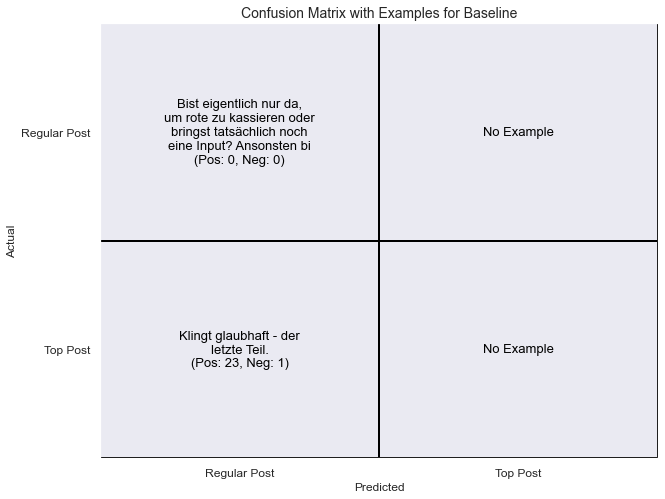

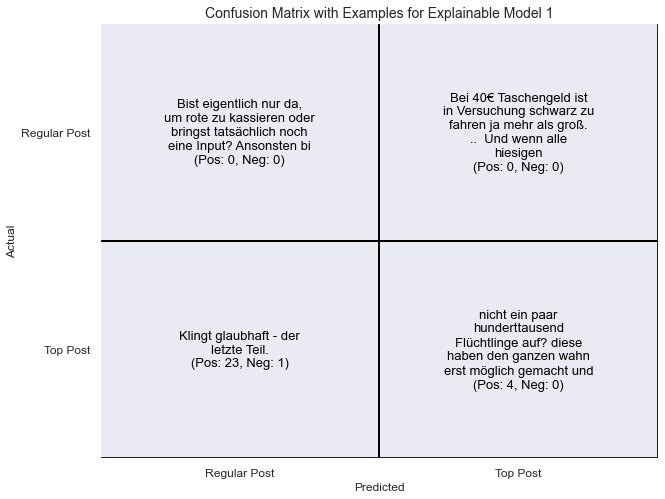

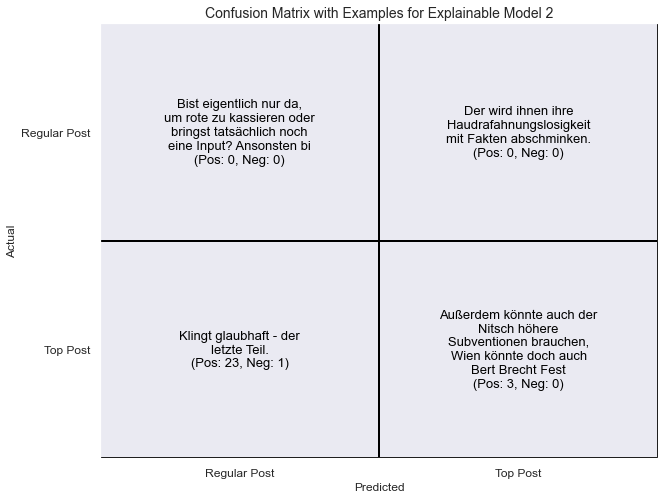

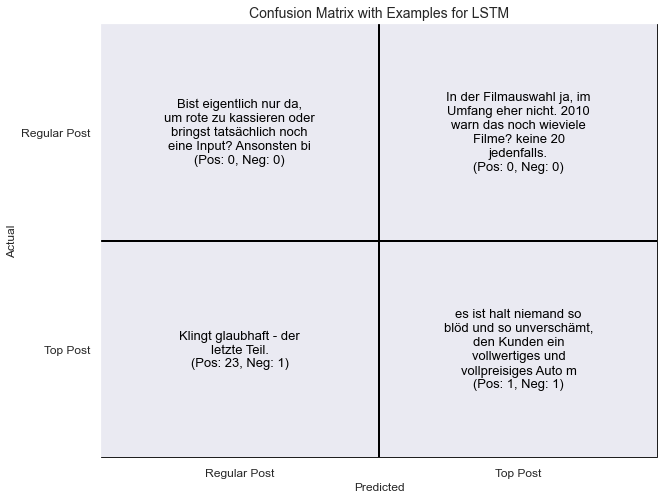

In [30]:

def format_example_text(example_text, pos_votes, neg_votes):
    """Format example text to display only the first 100 characters with line breaks every 25 characters."""
    if example_text:
        # Limit to 100 characters
        truncated_text = example_text[:100]
        # Create line breaks every 25 characters without cutting words
        wrapped_text = textwrap.fill(truncated_text, width=25)
        return f"{wrapped_text}\n(Pos: {pos_votes}, Neg: {neg_votes})"
    return "No Example"

def plot_confusion_matrix_of_examples(examples_df, model_name):
    """Plot the confusion matrix using the examples dataframe."""
    labels = ['Regular Post', 'Top Post']
    cm = [[0, 0], [0, 0]]  # Initialize confusion matrix counts

    # Fill confusion matrix based on examples_df
    for _, row in examples_df.iterrows():
        if row['Type'] == 'True Positive':
            cm[1][1] += 1
        elif row['Type'] == 'True Negative':
            cm[0][0] += 1
        elif row['Type'] == 'False Positive':
            cm[0][1] += 1
        elif row['Type'] == 'False Negative':
            cm[1][0] += 1

    plt.figure(figsize=(10, 8))  # Increase the overall size

    # Create a grid for the confusion matrix
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            # Draw rectangle for each cell
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))
            # Only annotate if there's a count
            if cm[i][j] > 0:
                # Find the corresponding example
                example_row = examples_df[(examples_df['Type'] == ('True Positive' if i == 1 and j == 1 else
                                                                    'True Negative' if i == 0 and j == 0 else
                                                                    'False Positive' if i == 0 and j == 1 else
                                                                    'False Negative'))]
                
                # Fetch the corresponding example text
                if not example_row.empty:
                    example = example_row.iloc[0]
                    formatted_text = format_example_text(example['Example'], 
                                                          example['PositiveVotes'], 
                                                          example['NegativeVotes'])
                else:
                    formatted_text = "No Example"
                    
                # Place the text in the center of each cell
                plt.text(j + 0.5, i + 0.5, formatted_text, ha='center', va='center', 
                         fontsize=13, color='black')

    # Set axis limits and labels
    plt.xlim(0, len(cm[0]))
    plt.ylim(0, len(cm))
    plt.title(f'Confusion Matrix with Examples for {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.xticks([0.5, 1.5], labels, fontsize=12)
    plt.yticks([0.5, 1.5], labels, fontsize=12)
    plt.gca().invert_yaxis()  # Invert y axis to have the origin in the top left

    plt.grid(False)  # Disable the grid
    plt.axis('on')  # Show the axes
    plt.show()

# Example call to plot the confusion matrix using examples_df
for model_name in examples_df['ModelName'].unique():
    model_examples_df = examples_df[examples_df['ModelName'] == model_name]
    plot_confusion_matrix_of_examples(model_examples_df, model_name)
